In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('../DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [7]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [8]:
df.columns = ['Sales']

In [9]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<Axes: xlabel='DATE'>

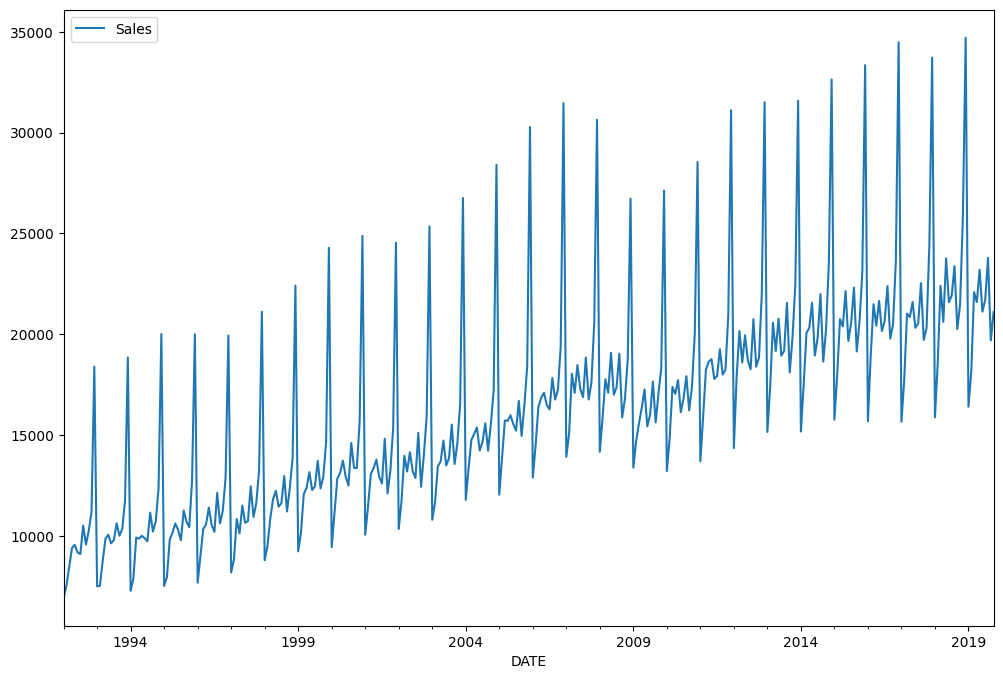

In [6]:
df.plot(figsize=(12,8))

### Train Test Split

In [7]:
len(df)

334

In [8]:
len(df) - 18

316

In [9]:
test_size = 18

In [10]:
test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [14]:
# Scale Data

from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [20]:
X,y = generator[0]

In [21]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [22]:
y

array([[0.02047633]])

### Create the Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
n_features = 1

In [25]:
input_shape = (length,n_features)

In [26]:
input_shape

(12, 1)

In [27]:

model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=input_shape))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
## Early Stopping

from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [31]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [32]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


C:\Users\Emirhan\AppData\Local\Temp\ipykernel_11252\3786894748.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])


304/304 [==============================] - 14s 39ms/step - loss: 0.0239 - val_loss: 0.0031
Epoch 2/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0184 - val_loss: 0.0022
Epoch 3/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0123 - val_loss: 0.0069
Epoch 4/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0057 - val_loss: 5.3424e-04
Epoch 5/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0025 - val_loss: 5.0171e-04
Epoch 7/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0019 - val_loss: 5.9182e-04
Epoch 8/20
304/304 [==============================] - 10s 32ms/step - loss: 0.0021 - val_loss: 0.0018


In [33]:
losses = pd.DataFrame(model.history.history)

<Axes: >

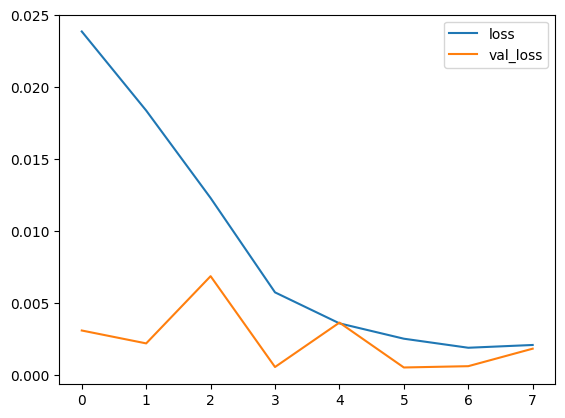

In [34]:
losses.plot()

### Evaluate on Test Data

In [35]:
first_eval_batch = scaled_train[-length:]

In [37]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [38]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 185ms/step


array([[0.4856493]], dtype=float32)

In [39]:
scaled_test[0]

array([0.61087714])

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
test['Predictions'] = true_predictions

C:\Users\Emirhan\AppData\Local\Temp\ipykernel_11252\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [44]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,20314.723980
2018-06-01,21589,19561.076847
2018-07-01,21919,19765.675057
2018-08-01,23381,21078.561458
2018-09-01,20260,19195.726653
2018-10-01,21473,19690.466475
2018-11-01,25831,22688.749144
2018-12-01,34706,30905.134961
2019-01-01,16410,15872.085186


<Axes: xlabel='DATE'>

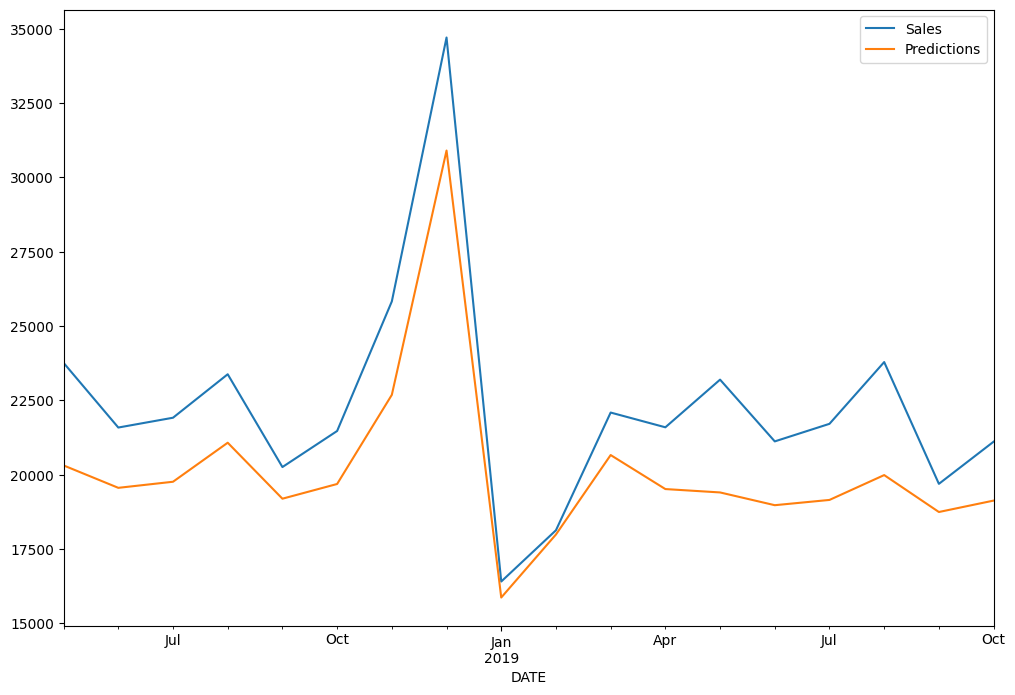

In [45]:
test.plot(figsize=(12,8))

### Retrain and Forecasting

In [46]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [47]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [48]:
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss= 'mse')

model.fit_generator(generator,epochs=8)

Epoch 1/8


C:\Users\Emirhan\AppData\Local\Temp\ipykernel_11252\2250840057.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 13s 37ms/step - loss: 0.0253
Epoch 2/8
322/322 [==============================] - 11s 36ms/step - loss: 0.0172
Epoch 3/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0112
Epoch 4/8
322/322 [==============================] - 11s 34ms/step - loss: 0.0047
Epoch 5/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0022
Epoch 6/8
322/322 [==============================] - 10s 31ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 10s 32ms/step - loss: 0.0024
Epoch 8/8
322/322 [==============================] - 10s 32ms/step - loss: 0.0015


In [49]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [50]:
forecast = scaler.inverse_transform(forecast)

In [51]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [52]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [53]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [54]:
forecast_df

,Forecast
2019-11-01,26829.451993
2019-12-01,35973.411974
2020-01-01,17030.842423
2020-02-01,18909.222339
2020-03-01,22846.596871
2020-04-01,22330.359971
2020-05-01,23951.013814
2020-06-01,21876.864201
2020-07-01,22490.755695
2020-08-01,24565.801704


<Axes: >

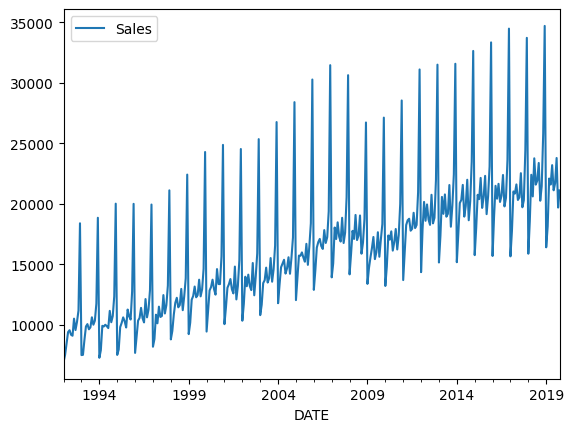

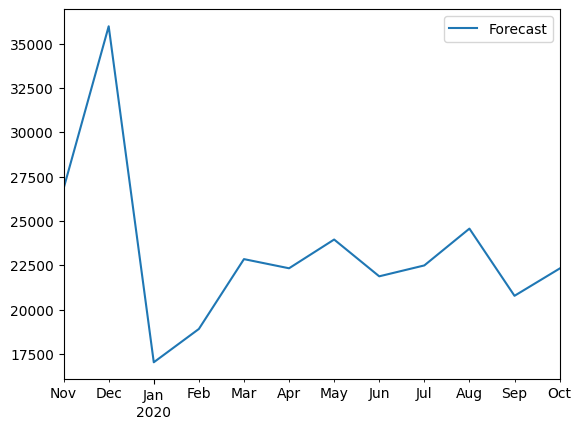

In [55]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

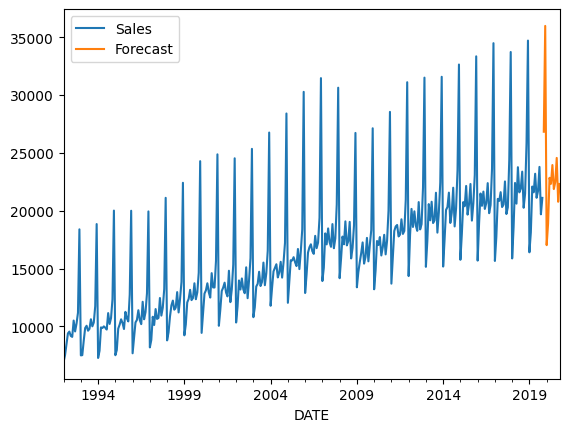

In [59]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

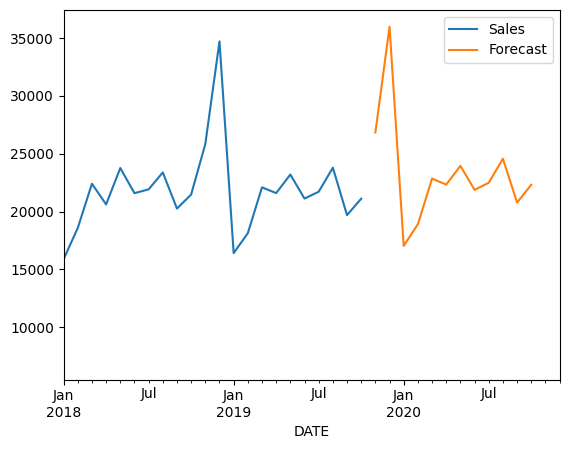

In [57]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')